# Capstone Project - Report for Arvato Financial Services
## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [9]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [10]:
# Importing train and test data
mailout_train = pd.read_csv('mailout_train_clean.csv')
mailout_test = pd.read_csv('mailout_test_clean.csv')

In [11]:
# Response distribution on training set
print('Frequency by response - train'.upper())
freq = pd.concat([mailout_train['RESPONSE'].value_counts(), round(mailout_train['RESPONSE'].value_counts(normalize=True),4)], axis=1)
freq.index.name = 'Response'
freq.columns = ['n', '%']
print(freq)

FREQUENCY BY RESPONSE - TRAIN
              n       %
Response               
0         42430  0.9876
1           532  0.0124


In [12]:
# Checking for missing values of 'RESPONSE'
mailout_train['RESPONSE'].isnull().sum()

0

In [13]:
# Defining predictors and target variables
features = list(mailout_train.drop(columns='RESPONSE'))
X_train = mailout_train[features]
y_train = np.array(mailout_train['RESPONSE'])
X_train.shape

(42962, 403)

### Adaboost

In [14]:
# Model fitting
dt = DecisionTreeClassifier(max_depth=5, random_state=82)
ada = AdaBoostClassifier(base_estimator=dt, random_state=82)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [15]:
# Model evaluation - training set
y_pred_train = ada.predict(X_train)
y_pred_proba = ada.predict_proba(X_train)[:,1]

print('------------------ TRAIN SET PERFORMANCE ------------------ \n')
print('Confusion matrix:\n', confusion_matrix(y_train, y_pred_train), '\n')
print('Classification report:\n', classification_report(y_train, y_pred_train))
print("Train set accuracy: {:.2f}".format(accuracy_score(y_train, y_pred_train)))
print("AUROC: {:.2f}".format(roc_auc_score(y_train, y_pred_proba)))

------------------ TRAIN SET PERFORMANCE ------------------ 

Confusion matrix:
 [[42430     0]
 [   65   467]] 

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42430
           1       1.00      0.88      0.93       532

    accuracy                           1.00     42962
   macro avg       1.00      0.94      0.97     42962
weighted avg       1.00      1.00      1.00     42962

Train set accuracy: 1.00
AUROC: 0.99


In [16]:
# Hyperparameters tuning
params_ada = {'n_estimators': [50, 100, 150], 'learning_rate':[0.001, 0.01, 0.05]}
grid_ada = GridSearchCV(estimator=ada, param_grid=params_ada, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_result_ada = grid_ada.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 34.7min finished


In [17]:
# Best score and parameters
print("Best: %f using %s" % (grid_result_ada.best_score_, grid_result_ada.best_params_))

# Grid search detailed results
means = grid_result_ada.cv_results_['mean_test_score']
stds = grid_result_ada.cv_results_['std_test_score']
params = grid_result_ada.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.762220 using {'learning_rate': 0.01, 'n_estimators': 100}
0.757446 (0.016519) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.760334 (0.015715) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.760176 (0.018091) with: {'learning_rate': 0.001, 'n_estimators': 150}
0.758013 (0.019642) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.762220 (0.018279) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.743059 (0.005671) with: {'learning_rate': 0.01, 'n_estimators': 150}
0.697357 (0.025895) with: {'learning_rate': 0.05, 'n_estimators': 50}
0.617979 (0.028555) with: {'learning_rate': 0.05, 'n_estimators': 100}
0.587815 (0.029340) with: {'learning_rate': 0.05, 'n_estimators': 150}


### Random forest

In [18]:
# Model fitting
rfc = RandomForestClassifier(random_state=82)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=82, verbose=0,
                       warm_start=False)

In [19]:
# Model evaluation - training set
y_pred_train = rfc.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[42430     0]
 [   65   467]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42430
           1       1.00      0.88      0.93       532

    accuracy                           1.00     42962
   macro avg       1.00      0.94      0.97     42962
weighted avg       1.00      1.00      1.00     42962



In [20]:
# Hyperparameters tuning
params_rfc = {'n_estimators': [300, 400, 500], 'min_samples_leaf':[50, 100, 200]}
grid_rfc = GridSearchCV(estimator=rfc, param_grid=params_rfc, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_result_rfc = grid_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  7.8min finished


In [21]:
# Best score and parameters
print("Best: %f using %s" % (grid_result_rfc.best_score_, grid_result_rfc.best_params_))

# Grid search detailed results
means = grid_result_rfc.cv_results_['mean_test_score']
stds = grid_result_rfc.cv_results_['std_test_score']
params = grid_result_rfc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.737471 using {'min_samples_leaf': 200, 'n_estimators': 300}
0.724264 (0.008137) with: {'min_samples_leaf': 50, 'n_estimators': 300}
0.724590 (0.009645) with: {'min_samples_leaf': 50, 'n_estimators': 400}
0.726355 (0.010606) with: {'min_samples_leaf': 50, 'n_estimators': 500}
0.735343 (0.012813) with: {'min_samples_leaf': 100, 'n_estimators': 300}
0.733663 (0.013174) with: {'min_samples_leaf': 100, 'n_estimators': 400}
0.733129 (0.013624) with: {'min_samples_leaf': 100, 'n_estimators': 500}
0.737471 (0.015930) with: {'min_samples_leaf': 200, 'n_estimators': 300}
0.736468 (0.014071) with: {'min_samples_leaf': 200, 'n_estimators': 400}
0.735977 (0.013631) with: {'min_samples_leaf': 200, 'n_estimators': 500}


In [22]:
# Model fitting
gbc = GradientBoostingClassifier(subsample=0.8, max_features='sqrt', random_state=82)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=82, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
# Model evaluation - training set
y_pred_train = gbc.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[42427     3]
 [  524     8]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42430
           1       0.73      0.02      0.03       532

    accuracy                           0.99     42962
   macro avg       0.86      0.51      0.51     42962
weighted avg       0.98      0.99      0.98     42962



In [24]:
# Hyperparameters tuning
params_gbc = {'max_depth': [4,6,8], 'n_estimators': [150, 200, 250], 'learning_rate':[0.001, 0.01, 0.1]}
grid_gbc = GridSearchCV(estimator=gbc, param_grid=params_gbc, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_result_gbc = grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 15.0min finished


In [25]:
# Best score and parameters
print("Best: %f using %s" % (grid_result_gbc.best_score_, grid_result_gbc.best_params_))

# Grid search detailed results
means = grid_result_gbc.cv_results_['mean_test_score']
stds = grid_result_gbc.cv_results_['std_test_score']
params = grid_result_gbc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.743404 using {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
0.731640 (0.011121) with: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 150}
0.734045 (0.011172) with: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 200}
0.730051 (0.011116) with: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 250}
0.718761 (0.019662) with: {'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 150}
0.723875 (0.019710) with: {'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 200}
0.724785 (0.018888) with: {'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 250}
0.722383 (0.014058) with: {'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 150}
0.729396 (0.015932) with: {'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 200}
0.734828 (0.017810) with: {'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 250}
0.737169 (0.016487) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150}
0.743404 (0.015717) with: {'learning_ra

In [26]:
# Model fitting
sgbc = GradientBoostingClassifier(max_depth=4, subsample=0.9, max_features=0.75, n_estimators=200, random_state=82)
sgbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=0.75, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=82, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
# Model evaluation - training set
y_pred_train = sgbc.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[42429     1]
 [  328   204]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42430
           1       1.00      0.38      0.55       532

    accuracy                           0.99     42962
   macro avg       0.99      0.69      0.77     42962
weighted avg       0.99      0.99      0.99     42962



In [29]:
# Hyperparameters tuning
params_sgbc = {'max_depth': [4,5], 'n_estimators': [100, 150], 'learning_rate':[0.0001, 0.001], 'subsample':[0.7, 0.75]}
#params_sgbc = {'max_depth': [2,4], 'n_estimators': [150, 250], 'learning_rate':[0.001, 0.1], 'subsample':[0.7, 0.85]}
#Best: 0.766198 using {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.7}
grid_sgbc = GridSearchCV(estimator=sgbc, param_grid=params_sgbc, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_result_sgbc = grid_sgbc.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 41.9min finished


In [30]:
# Best score and parameters
print("Best: %f using %s" % (grid_result_sgbc.best_score_, grid_result_sgbc.best_params_))

# Grid search detailed results
means = grid_result_sgbc.cv_results_['mean_test_score']
stds = grid_result_sgbc.cv_results_['std_test_score']
params = grid_result_sgbc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.766198 using {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.7}
0.763563 (0.015829) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
0.761722 (0.016745) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.75}
0.764019 (0.016899) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.7}
0.763152 (0.017638) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.75}
0.756593 (0.013968) with: {'learning_rate': 0.0001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
0.760479 (0.016287) with: {'learning_rate': 0.0001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75}
0.758111 (0.014762) with: {'learning_rate': 0.0001, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.7}
0.761932 (0.015626) with: {'learning_rate': 0.0001, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.75}
0.765468 (0.015668) with: {'learning_ra

In [31]:
grid_result_sgbc.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=4,
                           max_features=0.75, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=82, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Best model - feature importance

In [32]:
# Model fitting - SGBC
sgbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=4,
                           max_features=0.75, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=82, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
sgbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=4,
                           max_features=0.75, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=82, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
cv_auroc = cross_val_score(sgbc, X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='roc_auc', n_jobs=-1)
auroc = cv_auroc.mean()

print('Folds:', len(cv_auroc))
print('CV AUROC:', cv_auroc)
print('Overall AUROC: {:.2f}'.format(auroc))

Folds: 3
CV AUROC: [0.77841416 0.77183377 0.74687564]
Overall AUROC: 0.77


In [34]:
# Model evaluation - training set
y_pred_train = sgbc.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[42430     0]
 [  532     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42430
           1       0.00      0.00      0.00       532

    accuracy                           0.99     42962
   macro avg       0.49      0.50      0.50     42962
weighted avg       0.98      0.99      0.98     42962



C:\Users\Carlos Alberto\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Selecting top 10 features by importance
sgbc_feat_imp = pd.DataFrame({'Feature':X_train.columns,'Importance': sgbc.feature_importances_})
sgbc_feat_imp = sgbc_feat_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print('Number of features used as predictors:', sgbc_feat_imp.shape[0], '\n')

feat_imp_top10 = sgbc_feat_imp.head(10)
print('Top 10 most relevant')
feat_imp_top10

Number of features used as predictors: 403 

Top 10 most relevant


,Feature,Importance
0,D19_SOZIALES,0.345564
1,D19_KONSUMTYP,0.122586
2,ANZ_KINDER,0.076371
3,D19_KONSUMTYP_MAX,0.057181
4,CAMEO_DEU_2015_5F,0.019572
5,EINGEZOGENAM_HH_JAHR,0.016908
6,CAMEO_DEU_2015_1A,0.014102
7,D19_HANDWERK,0.012226
8,MIN_GEBAEUDEJAHR,0.011053
9,KBA05_SEG2,0.010980


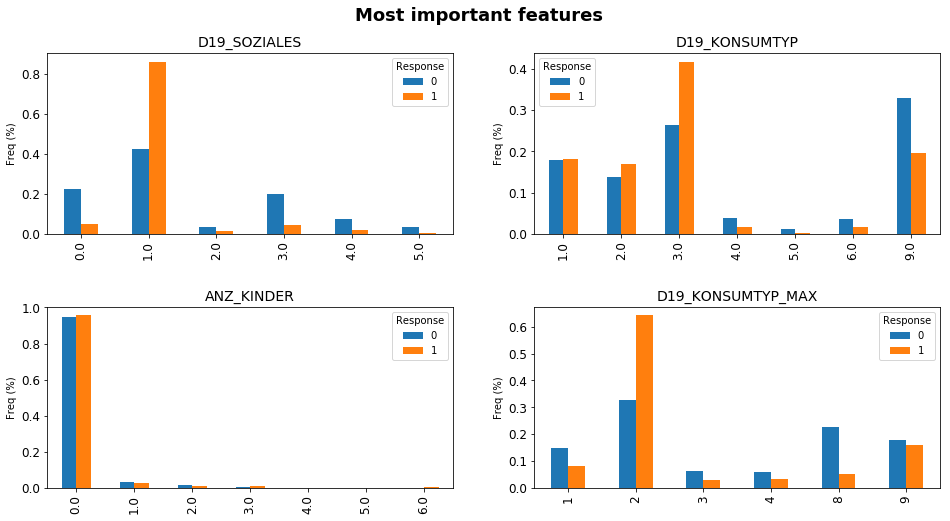

In [36]:
# Distribution of important features by RESPONSE

plt.rcParams.update({'ytick.labelsize': 12, 'xtick.labelsize': 12})

r, c = 2, 2 # rows, cols
ax_list = [[i,j] for i in range(0, r) for j in range(0, c)] # all rows and cols combinations

i = 0 # plot counter

fig, ax = plt.subplots(r, c, figsize=(16, 4*r))

fig.subplots_adjust(hspace=0.4)

for var in feat_imp_top10['Feature'][:4]:
    
    x = pd.crosstab(X_train[var], y_train, normalize='columns')
    x.columns.name = 'Response'

    ri=ax_list[i][0] # número da linha
    ci=ax_list[i][1] # número da coluna
    x.plot(kind='bar', ax=ax[ri, ci])
    ax[ri, ci].set_title('{}'.format(var), fontsize=14)
    ax[ri, ci].set_ylabel('Freq (%)')
    ax[ri, ci].set_xlabel('')
    #ax[ri, ci].set_xticks(x.index)
        
    i+=1

#plt.tight_layout()
plt.suptitle('Most important features', fontsize=18, y=0.96, weight='bold')
plt.show();